# YOLOv4 Kaggle Safety Helmet Detection

DarkNet: https://github.com/AlexeyAB/darknet

Reference notebook: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/YOLOv4_Training_Tutorial.ipynb

## Download Kaggle Safety Helmet Images and Annotations

Kaggle data: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection

In order to download Kaggle data directly into Colab, a Kaggle API token is needed:
https://www.kaggle.com/settings/account

In [ ]:
#!rm -r ~/.kaggle
!mkdir ~/.kaggle

In [ ]:
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

In [ ]:
#!unzip hard-hat-detection.zip

## Compiling Darknet on Colab

In [ ]:
# Verify cuda version.
!/usr/local/cuda/bin/nvcc --version

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# Enable GPU and OPENCV in Makefile.
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
!make

In [ ]:
# Download pretrained weights.
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
# Download partial weights for transfer learning.
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
# Download pretrained tiny weights.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

In [ ]:
# Download partial tiny weights for transfer learning.
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights

In [ ]:
# Copy the downloaded data .zip file into the darknet directory.
!cp ../hard-hat-detection.zip ./

In [ ]:
# This will be unzipped into 2 folders - `images` and `annotations`.
!unzip hard-hat-detection.zip

## Python Functions to Prepare Data

In [ ]:
import os

from google.colab import files

import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

In [ ]:
def xml_to_yolo_bbox(bndbox, image_size):
    # xml to yolo bounding box.
    xmin, xmax, ymin, ymax = bndbox
    # x and y mid points of the bounding box.
    x_mid = (xmin + xmax) * 0.5
    y_mid = (ymin + ymax) * 0.5
    # Height and width of the box.
    height = ymax - ymin
    width = xmax - xmin

    image_width, image_height = image_size
    image_width_inv = 1 / image_width
    image_height_inv = 1 / image_height

    x_mid = x_mid * image_width_inv
    width = width * image_width_inv
    y_mid = y_mid * image_height_inv
    height = height * image_height_inv
    return [x_mid, y_mid, width, height]

def xml_to_yolo(xml_file_path, txt_file_path, wanted_classes):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)

    output_string = ""

    for o in root.iter("object"):
        obj_class = o.find("name").text
        if obj_class in wanted_classes:
          obj_class_id = str(wanted_classes.index(obj_class))
          bndbox = o.find("bndbox")
          bndbox = [float(bndbox.find("xmin").text), 
                    float(bndbox.find("xmax").text),
                    float(bndbox.find("ymin").text),
                    float(bndbox.find("ymax").text)]

          yolo_box = xml_to_yolo_bbox(bndbox, [img_width, img_height])

          output_string = output_string + obj_class_id + " "
          output_string = output_string + " ".join([str(b) for b in yolo_box]) 
          output_string = output_string + "\n"
          
    with open(txt_file_path, "w") as f:
        f.write(output_string)

In [ ]:
# Prepare the obj.names, obj.data and .cfg files required for Yolov4 training.
wanted_classes = ["helmet", "head"]
image_extension = ".png"

# obj.names
obj_names_output_string = ""
for wc in wanted_classes:
    obj_names_output_string = obj_names_output_string + wc + "\n"

with open("obj.names", "w") as f:
    f.write(obj_names_output_string)

ann_xml_file_list = os.listdir("annotations/")
image_file_list = []

for i in os.listdir("images/"):
    if i[-4:] == image_extension:
        image_file_list.append(i)

print("{} images.".format(len(image_file_list)))

# .txt annotations.
for a in ann_xml_file_list:
    if a[-4:] == ".xml":
        file_root_name = a[:-4]
        if file_root_name + image_extension in image_file_list:
            txt_name = file_root_name + ".txt"
            xml_to_yolo(os.path.join("annotations/", a), 
                        os.path.join("images/", txt_name), 
                        wanted_classes)

train_image_list, test_image_list = train_test_split(image_file_list, test_size = 0.2, random_state = 42)
train_image_list.sort()
test_image_list.sort()
print("Train images: {}, test images: {}.".format(len(train_image_list), len(test_image_list)))

# train.txt
train_txt_output_string = ""
for f in train_image_list:
    train_txt_output_string = train_txt_output_string + "images/" + f + "\n"

with open("train.txt", "w") as f:
    f.write(train_txt_output_string)

# test.txt
test_txt_output_string = ""
for f in test_image_list:
    test_txt_output_string = test_txt_output_string + "images/" + f + "\n"

with open("test.txt", "w") as f:
    f.write(test_txt_output_string)

# obj.data
obj_data_output_string = """classes = 2
train = train.txt
valid = test.txt
names = obj.names
backup = backup"""

with open("obj.data", "w") as f:
    f.write(obj_data_output_string)

In [ ]:
#!cp cfg/yolov4-custom.cfg ./

In [ ]:
!cp cfg/yolov4-tiny-custom.cfg ./

In [ ]:
with open("yolov4-tiny-custom.cfg", "r") as f:
    cfg_string = f.read()

cfg_string = cfg_string.split("\n")

cfg_string[6] = "subdivisions=16"
cfg_string[19] = "max_batches=6000"
cfg_string[21] = "steps=4800,5400"
cfg_string[211] = "filters=21"
cfg_string[219] = "classes=2"
cfg_string[262] = "filters=21"
cfg_string[268] = "classes=2"

cfg_string = "\n".join(cfg_string)

with open("yolov4-tiny-custom.cfg", "w") as f:
    f.write(cfg_string)

In [ ]:
def imShow(path):
    image = cv2.imread(path)
    resized_image = image.copy() 
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

def upload():
    uploaded = files.upload() 
    for name, data in uploaded.items():
        with open(name, "wb") as f:
            f.write(data)
            print("saved file", name)

def download(path):
    files.download(path)

In [ ]:
#!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg -dont_show -out_filename predictions.jpg

In [ ]:
#!./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/person.jpg -dont_show -out_filename predictions.jpg

In [ ]:
#imShow("predictions.jpg")

## Transfer Learning Yolov4

In [ ]:
!./darknet detector train obj.data yolov4-tiny-custom.cfg yolov4-tiny.conv.29 -dont_show -map

## Testing the Finetuned Model

In [ ]:
!./darknet detector test obj.data yolov4-tiny-custom.cfg backup/yolov4-tiny-custom_last.weights images/hard_hat_workers10.png --dont_show --out_filename predictions.jpg

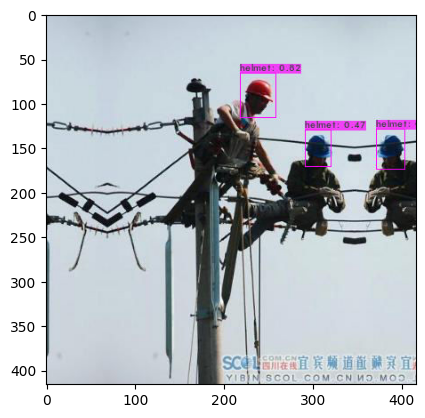

In [36]:
imShow("predictions.jpg")